In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import matplotlib.ticker as ticker


# Plot energy norm for IMEX-RB on 2D nonlinear problem
We show absolute stability of IMEX-RB

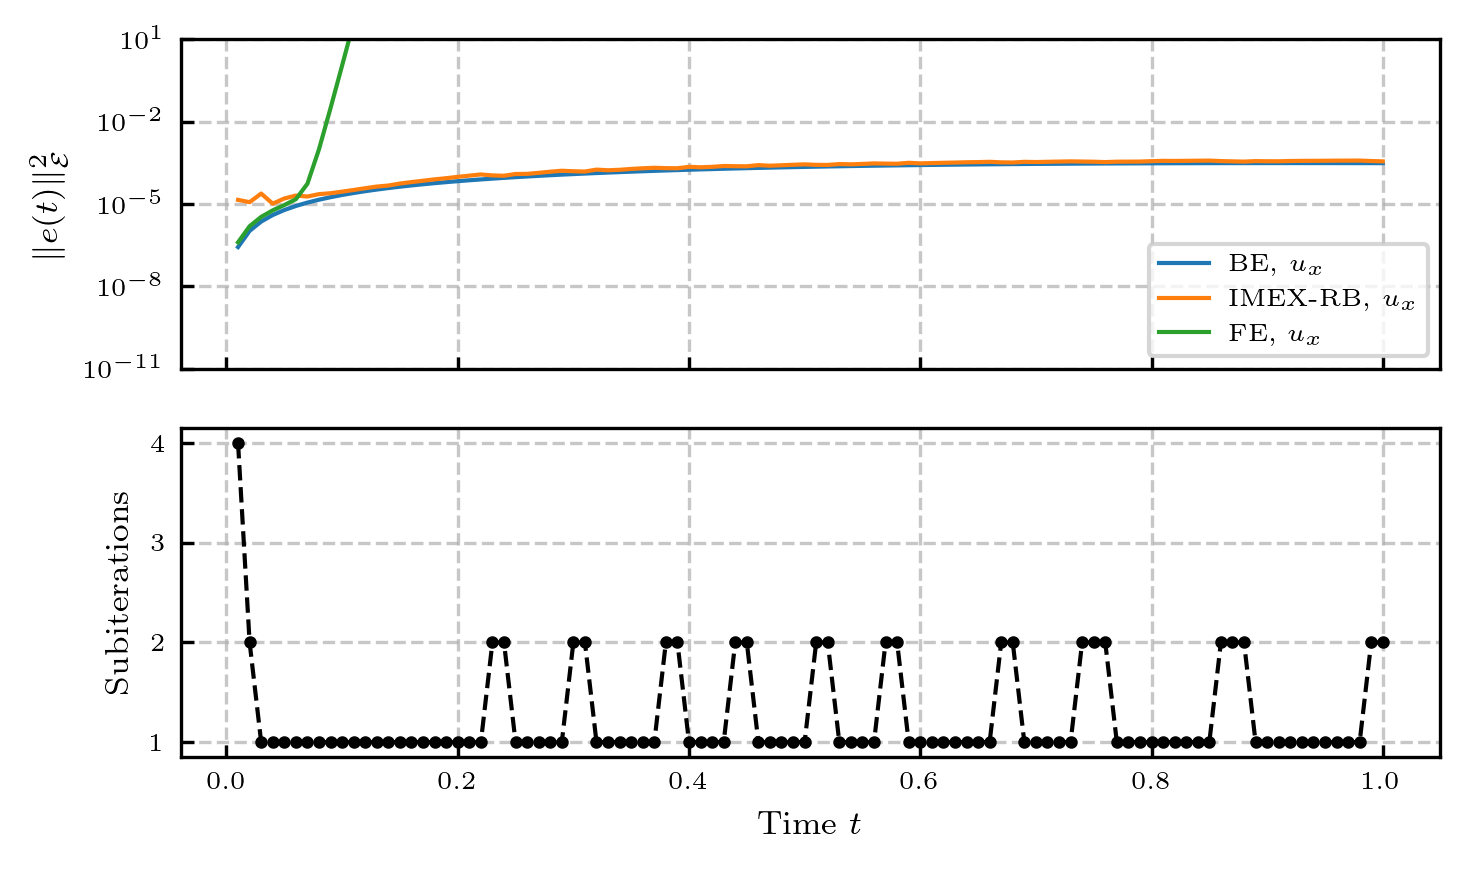

In [5]:
# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
results_path = os.path.join(
    base_dir, os.pardir, os.pardir, 'results',
    'Burgers2D', 'energynorm', 'Test2', 'results.npz'
)
plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_energy = data['errors_energy'].item()
subiters = data['subiters'].item()
Nt = data['Nt'].item()
tvec = np.linspace(0, 1, Nt + 1)

methods = ['BE', 'IMEX-RB', 'FE']
comp_labels = ['u_x']  # ['u_x', 'u_y']
linestyles = ['-', '--']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,3), sharex=True)

# First subplot: energy error
for i, comp in enumerate(comp_labels):
    for m in methods:
        e = errors_energy[m][i]
        ax1.semilogy(tvec[1:], e, linestyle=linestyles[i], 
                        label=f'{m}, ${comp}$')

ax1.set_ylabel(r'$\|e(t)\|_{\mathcal{E}}^2$')
ax1.set_ylim(bottom=1e-11, top=1e1)
# ax1.set_title('Error energy over time')
ax1.legend()

# Second subplot: subiters
ax2.plot(tvec[1:], subiters['IMEX-RB'], 'k--',  marker='o', label='IMEX-RB')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Subiterations')
# ax2.set_title('Number of Subiterations Over Time')
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.grid(True)

plt.tight_layout()
out_file = os.path.join(plots_dir, 'Burgers2D_errors_subiters.pdf')
plt.savefig(out_file)
plt.show()
plt.close()